In [16]:
from ncmw.analysis.similarity import jaccard_similarity_matrices, jaccard_similarity
from ncmw.analysis.medium import compute_COMPM
from ncmw.workflows.utils import get_models, get_result_path, SEPERATOR
from ncmw.setup_models.utils import get_default_medium
from ncmw.setup_models.setup import gapfill_medium, set_default_configs_and_snm3_medium
from ncmw.analysis.sekretion_uptake import transport_reactions, table_ex_transport

import matplotlib.pyplot as plt
import numpy as np

from cobra.flux_analysis import flux_variability_analysis

import cobra

In [ ]:
import cobra 
import numpy as np 
import scipy 

from mip import xsum, maximize, BINARY
import mip

from abc import ABC, abstractmethod, abstractproperty
import typing

import sys, os
import tempfile

import pickle

import pandas as pd

def create_stoichiometry_matrix(model):
    """ This creates a stoichiometry matrix"""
    metabolites = model.metabolites 
    reactions = model.reactions 
    S = np.zeros((len(metabolites), len(reactions)))
    
    met_id = dict()
    rec_id = dict()
    for i,reaction in enumerate(model.reactions):
        rec_id[reaction.id] = i
        for metabolite, stoich in reaction.metabolites.items():
            met_id[metabolite.id] = int(metabolites.index(metabolite))
            S[metabolites.index(metabolite), i] = stoich
    # Compress as sparse matrix
    S = scipy.sparse.csr_matrix(S)
    return S, met_id, rec_id 

def get_biomass_reaction(model):
    """ Return the biomass reaction of a model """
    objective_str = str(list(model.objective.variables)[0])
    for rec in model.reactions:
        if rec.id in objective_str:
            return rec

class CommunityModel(ABC):
    """This gives the backbone of any community model.
    """
    @property
    def medium(self):
        return self._medium 

    @medium.setter
    def medium(self, medium):
        return self._set_medium(medium)
    
    @abstractmethod
    def _set_medium(self, medium):
        """ This method should set the medium properly"""
        pass

    @property
    def weights(self):
        return self._weights

    @weights.setter
    def weights(self, weights):
        return self._set_weights(weights)
    
    @abstractmethod
    def _set_weights(self, weights):
        """ This method should set the weights properly"""
        pass

    @abstractmethod
    def slim_optimize(self):
        """ This method returns the current objective value"""
        pass

    @abstractmethod
    def single_optimize(self, idx):
        """ This method returns the current objective value"""
        pass
    
    @abstractmethod
    def optimize(self):
        """ This method return the current objective value and additional information """
        pass

    def computeCOOPM(self, MBR, fraction=0.1, enforce_survival=True):
        """ This method computes the COOPM medium """
        raise NotImplementedError("This method is not implemented fro your current model")

    def summary(self):
        """ This method should report a summary of the model"""
        raise NotImplementedError("This method is not implemented for your current model")

    def save(self, path):
        """ This saves the model using pickle. For other format overwrite this function"""
        with open(path + ".pkl","wb+") as f:
            pickle.dump(self,f)
    def load(self, path):
        with open(path + ".pkl","wb") as f:
            self = pickle.load(f)


class BagOfReactionsModel(CommunityModel):
    """This is a community model, which treats the community as a bag of all reactions that at least one the species has. 
    """
    def __init__(self, models:list):
        self.community_model = cobra.Model("Community__" + "".join([model.id + "__" for model in models]))
        for model in models:
            self.community_model += model
        self.models = models
        self._weights = np.ones(len(models))
        self._medium = self.community_model.medium
        self.biomass_reactions = [get_biomass_reaction(model) for model in models]
        self.objective = sum([f.flux_expression for f in self.biomass_reactions])
        self.community_model.objective = self.objective

    def _set_medium(self, medium):
        self.community_model.medium = medium 
        self._medium = medium 

    def _set_weights(self, weights):
        assert len(weights) == len(self.models), "You need to specify for each species in the community a weights..."
        self._weights = weights 
        self.objective = sum([weights[i]*self.biomass_reactions[i].flux_expression for i in range(len(self.weights))])
        self.community_model.objective = self.objective

    def slim_optimize(self):
        return self.community_model.slim_optimize()

    def optimize(self):
        sol = self.community_model.optimize()
        total_growth = self.community_model.slim_optimize()
        single_growths = [sol[r.id] for r in self.biomass_reactions]
        return total_growth, single_growths

    def single_optimize(self, idx):
        weights = np.zeros(len(self.models))
        weights[idx] = 1. 
        old_weights = self._weights
        self._set_weights(weights)
        growth = self.slim_optimize()
        self._set_weights(old_weights)

        return growth

    def summary(self):
        return self.community_model.summary()

    def computeCOOPM(self, MBR, fraction=0.1, enforce_survival=True):
        model = self.community_model.copy()
        minMBR = fraction*MBR
        medium = list(model.medium.keys())
        biomass = [model.reactions.get_by_id(f.id).flux_expression for f in self.biomass_reactions]

        # Binary variables: Theta_i 
        thetas = []
        for i in range(len(medium)):
            thetas.append(model.problem.Variable('theta_'+str(i), type="binary"))

        # Constraints for exchanges, which are turned of for theta_i = 1
        theta_constraints = []
        for i,id in enumerate(medium):
            reaction = model.reactions.get_by_id(id)
            min_bound = model.reactions.get_by_id(id).lower_bound
            cons = model.problem.Constraint(
                (reaction.flux_expression + min_bound*thetas[i]),
                lb=min_bound,
                ub=1000)
            theta_constraints.append(cons)

        # Constraints for growth rates, which must be at least 10% MBR
        if enforce_survival:
            constraint_growth = [model.problem.Constraint(
            f,
            lb=self.weights[i]*minMBR,
            ub=1000) for i,f in enumerate(biomass)]
        else:
            constraint_growth = model.problem.Constraint(
            sum(biomass),
            lb=minMBR,
            ub=1000)

        # Adding new variables and constraints.
        model.add_cons_vars(thetas)
        model.add_cons_vars(theta_constraints)
        model.add_cons_vars(constraint_growth)

        # Objevtive is maximising turned of exchanges, that is sum of theta_is
        objective = model.problem.Objective(sum(thetas), direction="max")
        model.objective = objective
        model.solver.update()

        sol = model.optimize()
        COOPM = dict()
        for id in medium:
            if sol.fluxes[id] < 0:
                COOPM[id] = abs(sol.fluxes[id])

        return COOPM 

class ShuttleCommunityModel(CommunityModel):
    def __init__(self,models, shared_exchanges=None):
        # Set up model data
        self.models = models
        self.stoichiometry_matrixes = []
        self.rec_id_dicts = []
        self.met_id_dicts = []
        self._medium = []
        for model in models:
            S, met_id, rec_id = create_stoichiometry_matrix(model)
            self.stoichiometry_matrixes.append(S)
            self.rec_id_dicts.append(rec_id)
            self.met_id_dicts.append(met_id)
            self._medium += list(model.medium.items())
        self._medium = dict(self._medium)
        self._bounds = self._get_bounds()



        # Set shuttle reactions to all exchanges if not specified
        if shared_exchanges is None:
            self.shared_exchanges = []
            for model in models:
                for ex in model.exchanges:
                    if ex.id not in self.shared_exchanges:
                        self.shared_exchanges.append(ex.id)

        self._weights = np.ones(len(models))
        self.biomass_reactions = [get_biomass_reaction(model) for model in models]
        self.biomass_ids = [self.rec_id_dicts[i][self.biomass_reactions[i].id] for i in range(len(models))]

        self.comm_model = mip.Model("Community Model")
        self.build_mip_model()

    def _set_weights(self, weights):
        self._weights = weights 
        self.objective = xsum([self.weights[i]*self.xs[i][self.biomass_ids[i]] for i in range(len(self.xs))])
        self.comm_model.objective = maximize(self.objective)

    def _set_medium(self, medium):
        self._medium = medium
        for key in self.shuttel_reactions:
            if key in medium:
                self.shuttel_reactions[key].lb = -medium[key]
                self.medium[key] = -medium[key]
            else:
                self.shuttel_reactions[key].lb = 0.
                self.medium[key] = 0.

    def optimize(self):
        self.comm_model.optimize()
        total_growth = self.objective.x 
        single_growths = []
        for x, id in zip(self.xs, self.biomass_ids):
            single_growths.append(x[id].x)
        return total_growth, single_growths

    def single_optimize(self, idx):
        weights = np.zeros(len(self.models))
        weights[idx] = 1. 
        old_weights = self._weights
        self._set_weights(weights)
        growth = self.slim_optimize()
        self._set_weights(old_weights)
        return growth

    def slim_optimize(self):
        self.comm_model.optimize()
        return self.objective.x

    def _get_exchange_flux(self):
        exchanges = []
        for j,rec_id in enumerate(self.rec_id_dicts):
            ex_dict ={}
            for key, val in rec_id.items():
                if "EX_" in key:
                    ex_dict[key] = self.xs[j][val].x 
            exchanges.append(ex_dict)
    
        return exchanges


    def summary(self):
        self.optimize()
        exchanges = self._get_exchange_flux()
        shared_ex = set(exchanges[0].keys()).intersection(*[set(ex.keys()) for ex in exchanges[1:]])
        titles = [model.id + " flux" for model in self.models]
        columns = [[] for _ in range(len(self.models))]
        interchange = dict(zip(titles,columns))
        index = shared_ex
        for key in index:
            for i in range(len(titles)):
                interchange[titles[i]].append(exchanges[i][key])
        df = pd.DataFrame(interchange)
        df.index = index 
        print("Objective: ", self.objective.x)
        for i in range(len(self.models)):
            print(self.models[i].id + " : ", self.xs[i][self.biomass_ids[i]].x, " with weights ", self.weights[i])
        return df

    def _reset_model(self):
        model = mip.Model()
        model.read(self.path)
        for key in self.shared_exchanges:
            x = model.var_by_name(key)
            self.shuttle_reactions[key] = x
        for j,x in enumerate(self.xs):
            for i in range(len(self._bounds[i])):
                x_i = model.var_by_name(f"x{j}" + str(i))
                x[i] += [x_i]
      
        self.comm_model = model

    def build_mip_model(self):
        ids = [[] for _ in range(len(self.rec_id_dicts))]
        x_sh = []
        x_sh_dict = {}
        for key in self.shared_exchanges:
            if key in self._medium:
                val = self._medium[key]
            else:
                val = 0
            x = self.comm_model.add_var(lb=-val, ub=1000, name=key)
            x_sh_dict[key] = x
            x_sh += [x]
            for j, rec_id in enumerate(self.rec_id_dicts):
                if key in rec_id:
                    ids[j] += [rec_id[key]]
                else:
                    ids[j] += [None]

        # Flux first model
        xs = []
        for j,bounds in enumerate(self._bounds):
            xs_j = []
            for i, (lb, ub) in enumerate(bounds): 
                xs_j += [self.comm_model.add_var(lb = lb, ub=ub, name=f"x{j}" + str(i))]
            xs.append(xs_j)

        # Stoichiometry
        for k, S in enumerate(self.stoichiometry_matrixes):
            for i in range(S.shape[0]):
                self.comm_model.add_constr(xsum(S[i,j]*xs[k][j] for j in range(S.shape[1])) == 0)

        # Shuttel constraints
        for i,key in enumerate(self.shared_exchanges):
            exchanges = [xs[k][ids[k][i]] for k in range(len(ids)) if ids[k][i] is not None]
            self.comm_model.add_constr(-x_sh[i] + xsum(exchanges) == 0)

        fd, path = tempfile.mkstemp()
        path = path + ".lp"
        self.comm_model.write(path)
            
        self.path = path
        self.shuttle_reactions = x_sh_dict
        self.xs = xs
        self.objective = xsum([self.weights[i]*self.xs[i][self.biomass_ids[i]] for i in range(len(self.xs))])
        self.comm_model.objective = maximize(self.objective)

    def computeCOOPM(self, MBR, fraction=0.1,enforce_survival=True):
        minMBR = fraction*MBR
        # thetas
        thetas = []
        thetas_constraint = []
        for key,x in self.shuttel_reactions.items():
            # TODO SET THIS TO THE MEDIUM??? Thats actually wrong...
            V_min = -10
            if key == "EX_o2_e":
                V_min = -20
            if "_fe" in key:
                V_min = -0.1
            theta = self.comm_model.add_var(var_type=BINARY)
            thetas_constraint += [self.comm_model.add_constr(x + V_min*theta >= V_min)]
            thetas.append(theta)
        # Both must grow
        if enforce_survival:
            for i in range(len(self.models)):
                self.comm_model.add_constr(self.xs[i][self.biomass_ids[i]] >= self.weights[i]*minMBR)
        else:
            self.comm_model.add_constr(self.objective >= minMBR)

        self.comm_model.objective = maximize(xsum(thetas))
        self.comm_model.optimize()

        coopm = dict()
        for key, x in self.shuttel_reactions.items():
            if x.x < 0:
                coopm[key] = abs(x.x)
        self.reset_model()
        return coopm

    def compute_convex_combination(self, alphas, maxbiomass=0.1):
        assert sum(alphas) == 1, "The weights must sum to one!"
        assert len(alphas) == len(self.models), "Scpecify a weight for each model..."
        assert max([self.single_optimize(i) for i in range(len(alphas))]) > maxbiomass, "Each of the models must reach the maxbiomass..."
        # Alpha objective...
        for i in range(len(alphas)):
            self.comm_model.add_constr(self.weights[i]*self.x1[self.obj1] <= alphas[i]*maxbiomass)
        growth = self.optimize()
        summary = self.summary()
        self.reset_model()
        return growth, summary

    def compute_convex_COOPM(self, alphas, maxbiomass=0.1, fraction=0.1, enforce_survival=True):
        assert sum(alphas) == 1, "The weights must sum to one!"
        assert len(alphas) == len(self.models), "Scpecify a weight for each model..."
        minMBR = maxbiomass*fraction
        thetas = []
        thetas_constraint = []
        for key,x in self.shuttel_reactions.items():
            V_min = -10
            if key == "EX_o2_e":
                V_min = -20
            if "_fe" in key:
                V_min = -0.1
            theta = self.comm_model.add_var(var_type=BINARY)
            thetas_constraint += [self.comm_model.add_constr(x + V_min*theta >= V_min)]
            thetas.append(theta)
        # Growth constraints
        for i in range(len(alphas)):
            self.comm_model.add_constr(self.weights[i]*self.x1[self.obj1] <= alphas[i]*maxbiomass)
        # Both must grow
        if enforce_survival:
            for i in range(len(self.models)):
                self.comm_model.add_constr(self.weights[i]*self.xs[i][self.biomass_ids[i]] >= alphas[i]*minMBR)
        else:
            self.comm_model.add_constr(self.objective >= minMBR)

        self.comm_model.objective = maximize(xsum(thetas))
        self.comm_model.optimize()

        coopm = dict()
        for key, x in self.shuttel_reactions.items():
            if x.x < 0:
                coopm[key] = abs(x.x)
        self.reset_model()
        return coopm

    def _get_bounds(self):
        all_bounds = []
        for model in self.models:
            bounds = []
            for rec in model.reactions:
                bounds.append((rec.lower_bound, rec.upper_bound))
            all_bounds.append(bounds)
        return all_bounds

    def save(self, path):
        """ This saves the model using pickle. For other format overwrite this function"""
        self.comm_model.write(path + ".lp")
    def load(self, path):
        self.path = path + ".lp"
        self._reset_model()



In [47]:
S,d1,d2 = create_stoichiometry_matrix(models[0])
S = scipy.sparse.csr_matrix(S)

In [36]:
import tempfile
fd, path = tempfile.mkstemp()
model.comm_model.write(path + ".lp")

In [10]:
#model = ShuttleCommunityModel(models)

In [68]:
model.weights = [0.2,0.7]

In [71]:
model.computeCOOPM(model.slim_optimize()*0.1)

{'EX_cl_e': 0.01076339613252814,
 'EX_arg__L_e': 8.22950179172132e-16,
 'EX_k_e': 0.019019650347396083,
 'EX_ca2_e': 0.009297443697048784,
 'EX_mg2_e': 0.015752872721579096,
 'EX_mn2_e': 0.006816227994831694,
 'EX_cobalt2_e': 0.006322801892487114,
 'EX_zn2_e': 0.005713371870009552,
 'EX_cu2_e': 0.005863830115039843,
 'EX_o2_e': 20.000000000000004,
 'EX_fe2_e': 0.014099071034264127,
 'EX_so4_e': 2.205513048963897,
 'EX_thm_e': 6.141768325809696e-05,
 'EX_cys__L_e': 8.777700788442644e-16,
 'EX_na1_e': 0.1178767814290818,
 'EX_ni2_e': 0.006348634573739494,
 'EX_nac_e': 8.001429186756285,
 'EX_mobd_e': 3.577180305507086e-07,
 'EX_ser__L_e': 1.3322676295501877e-15}

In [76]:
coopm = model.computeCOOPM(model.slim_optimize()*0.1)

In [79]:
model.medium = coopm 
model.slim_optimize()

0.07154360611014154

In [73]:
df = pd.DataFrame(dict(zip([m.id for m in model.models], np.round(sol[1], 2))), index=[0])
df["Total"] = sol[0]
df["Weight"] = str(model.weights)
df = df.append(df)
df["Medium"] = "snm3"
df

,DP_83VPs_KB5_consistent_snm3,iYS854_consistent_snm3,Total,Weight,Medium
0,0.35,5.01,3.57718,"[0.2, 0.7]",snm3
0,0.35,5.01,3.57718,"[0.2, 0.7]",snm3


In [50]:
model = BagOfReactionsModel(models)

Ignoring reaction 'ACALD' since it already exists.
Ignoring reaction 'ACALDt' since it already exists.
Ignoring reaction '3OAS140' since it already exists.
Ignoring reaction '3OAS60' since it already exists.
Ignoring reaction 'ACCOAC' since it already exists.
Ignoring reaction '5DOAN' since it already exists.
Ignoring reaction '6PHBG' since it already exists.
Ignoring reaction '6PHBG2' since it already exists.
Ignoring reaction 'ACGS' since it already exists.
Ignoring reaction 'ACKr' since it already exists.
Ignoring reaction '3HAD100' since it already exists.
Ignoring reaction '3HAD120' since it already exists.
Ignoring reaction '3HAD140' since it already exists.
Ignoring reaction 'ACACT1r' since it already exists.
Ignoring reaction '3HAD60' since it already exists.
Ignoring reaction 'ACM6PH' since it already exists.
Ignoring reaction '3OAR100' since it already exists.
Ignoring reaction '3OAR140' since it already exists.
Ignoring reaction '3OAR60' since it already exists.
Ignoring rea

In [95]:
summary = model.summary()
pd.DataFrame({"d1":[summary], "d2":[summary]})

,d1,d2
0,DP_83VPs_KB5_consistent_snm3 flux...,DP_83VPs_KB5_consistent_snm3 flux...


In [96]:
model.medium

{'EX_glc__D_e': 10.0,
 'EX_h2o_e': 10.0,
 'EX_leu__L_e': 10.0,
 'EX_4abz_e': 10.0,
 'EX_ala__L_e': 10.0,
 'EX_cl_e': 10.0,
 'EX_pi_e': 10.0,
 'EX_ribflv_e': 10.0,
 'EX_gly_e': 10.0,
 'EX_thr__L_e': 10.0,
 'EX_arg__L_e': 10.0,
 'EX_lys__L_e': 10.0,
 'EX_orn_e': 10.0,
 'EX_k_e': 10.0,
 'EX_pro__L_e': 10.0,
 'EX_ca2_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_mn2_e': 10.0,
 'EX_cobalt2_e': 10.0,
 'EX_zn2_e': 10.0,
 'EX_succ_e': 10.0,
 'EX_co2_e': 10.0,
 'EX_cu2_e': 10.0,
 'EX_o2_e': 20.0,
 'EX_glu__L_e': 10.0,
 'EX_fe2_e': 0.1,
 'EX_fum_e': 10.0,
 'EX_his__L_e': 10.0,
 'EX_ile__L_e': 10.0,
 'EX_met__L_e': 10.0,
 'EX_so4_e': 10.0,
 'EX_trp__L_e': 10.0,
 'EX_val__L_e': 10.0,
 'EX_thm_e': 10.0,
 'EX_cys__L_e': 10.0,
 'EX_phe__L_e': 10.0,
 'EX_na1_e': 10.0,
 'EX_ni2_e': 10.0,
 'EX_nac_e': 10.0,
 'EX_26dap__M_e': 10.0,
 'EX_mobd_e': 10.0,
 'EX_pyr_e': 10.0,
 'EX_ser__L_e': 10.0,
 'EX_urea_e': 10.0}

In [41]:
coopm = model.computeCOOPM(1.)

[1.0*Growth - 1.0*Growth_reverse_699ae, 1.0*BIOMASS_iYS_wild_type - 1.0*BIOMASS_iYS_wild_type_reverse_4a71b]


In [3]:
PATH = get_result_path("default_project_name") + SEPERATOR + "setup" + SEPERATOR + "snm3_models"

In [4]:
models = get_models("", prefix=PATH)

In [7]:
fva = flux_variability_analysis(models[0])
fva2 = flux_variability_analysis(models[1])


In [4]:
from ncmw.analysis.sekretion_uptake import sekretion_uptake_fva, compute_uptake_sekretion_table, compute_all_uptake_sekretion_tables

In [6]:
compute_all_uptake_sekretion_tables(models, fvas=[fva,fva2])[0]

,DP_83VPs_KB5_consistent_snm3 Uptake,DP_83VPs_KB5_consistent_snm3 Secretion,DP_83VPs_KB5_consistent_snm3 -> iYS854_consistent_snm3,iYS854_consistent_snm3 -> DP_83VPs_KB5_consistent_snm3,iYS854_consistent_snm3 Secretion,iYS854_consistent_snm3 Uptake
0,EX_26dap__M_e,EX_arg__L_e,na,na,DM_5drib_c,EX_acald_e
1,EX_4abz_e,EX_cl_e,na,na,DM_amob_c,EX_co2_e
2,EX_ala__L_e,EX_cys__L_e,na,na,EX_co2_e,EX_for_e
3,EX_arg__L_e,EX_fe2_e,na,na,EX_etoh_e,EX_fum_e
4,EX_ca2_e,EX_glc__D_e,na,na,EX_glyclt_e,EX_glyclt_e
5,EX_cl_e,EX_glu__L_e,na,na,EX_h2o_e,EX_h2o_e
6,EX_cobalt2_e,EX_his__L_e,na,na,EX_lac__D_e,EX_orn_e
7,EX_cu2_e,EX_k_e,na,na,EX_nh4_e,na
8,EX_cys__L_e,EX_leu__L_e,na,na,EX_urea_e,na
9,EX_fe2_e,EX_lys__L_e,na,na,SK_ahcys_c,na


In [12]:
up1 , sek1 = sekretion_uptake_fva(fva)
up2 , sek2 = sekretion_uptake_fva(fva2)

In [14]:
compute_uptake_sekretion_table(models[0].id, models[1].id, up1, sek1, up2, sek2)

,DP_83VPs_KB5_consistent_snm3 Uptake,DP_83VPs_KB5_consistent_snm3 Secretion,DP_83VPs_KB5_consistent_snm3 -> iYS854_consistent_snm3,iYS854_consistent_snm3 -> DP_83VPs_KB5_consistent_snm3,iYS854_consistent_snm3 Secretion,iYS854_consistent_snm3 Uptake
0,EX_glc__D_e,EX_arg__L_e,EX_orn_e,EX_h2o_e,EX_istfrnA_e,EX_12ppd__S_e
1,EX_h2o_e,EX_his__L_e,na,EX_arg__L_e,EX_istfrnB_e,EX_h2o_e
2,EX_leu__L_e,EX_k_e,na,EX_ile__L_e,EX_stfrnA_e,EX_h_e
3,EX_4abz_e,EX_leu__L_e,na,EX_co2_e,EX_stfrnB_e,EX_LalaDgluMdap_e
4,EX_ala__L_e,EX_lys__L_e,na,EX_met__L_e,EX_ac_e,EX_ala__L_e
5,EX_cl_e,EX_cl_e,na,EX_pi_e,EX_acald_e,EX_acald_e
6,EX_pi_e,EX_cys__L_e,na,na,EX_acgam_e,EX_nh4_e
7,EX_ribflv_e,EX_mg2_e,na,na,EX_aglaa_e,EX_ala__D_e
8,EX_gly_e,EX_mn2_e,na,na,EX_glyald_e,EX_anhgm_e
9,EX_thr__L_e,EX_mobd_e,na,na,EX_glyc_e,EX_orn_e


In [10]:
table_ex_transport(model)

In [47]:
def check_transport_DP(reaction):
    react = reaction.reaction
    if "_p" in react and "_c" in react:
        return True
    elif "_p" in react and "_e" in react:
        return True
    elif "_c" in react and "_e" in react:
        return True
    else:
        return False

transport_reactions_DP = [trp for trp in model.reactions if check_transport_DP(trp)]
print("Number of transport reactions: ", len(transport_reactions_DP))

Number of transport reactions:  267


In [49]:
for x in transport_reactions_DP:
    if "transport" not in x.name:
        print(x)

ABZtex: 4abz_e <=> 4abz_c
ACTNabc1: actn__R_c + atp_c + h2o_c --> actn__R_e + adp_c + h_c + pi_c
AGMPTRCtpp: agm_p + ptrc_c <=> agm_c + ptrc_p
ALAt4: ala__L_e + na1_e --> ala__L_c + na1_c
ARGAGMt7pp: agm_c + arg__L_p <=> agm_p + arg__L_c
ARGORNt7pp: arg__L_p + orn_c <=> arg__L_c + orn_p
CA2abc1: atp_c + ca2_c + h2o_c --> adp_c + ca2_e + h_c + pi_c
CRNt7pp: crn_p + gbbtn_c --> crn_c + gbbtn_p
Cut1: atp_c + cu2_c + h2o_c --> adp_c + cu2_e + h_c + pi_c
CYSabc2pp: atp_c + cys__L_c + h2o_c --> adp_c + cys__L_p + h_c + pi_c
CYSabcpp: atp_c + cys__L_p + h2o_c --> adp_c + cys__L_c + h_c + pi_c
CYTBD2: 2.0 h_c + mql8_c + 0.5 o2_c --> h2o_c + 2.0 h_e + mqn8_c
GLUt4: glu__L_e + na1_e --> glu__L_c + na1_c
GTHRDabc2pp: atp_c + gthrd_c + h2o_c --> adp_c + gthrd_p + h_c + pi_c
GTHRDabcpp: atp_c + gthrd_p + h2o_c --> adp_c + gthrd_c + h_c + pi_c
H2St: h2s_e <=> h2s_c
MPTG: 2.0 uaagmda_c --> 2.0 h_c + murein5p5p_p + 2.0 udcpdp_c
NADH17pp: 4.0 h_c + mqn8_c + nadh_c --> 3.0 h_p + mql8_c + nad_c
NADH7: 3.

In [22]:
model = set_default_configs_and_snm3_medium(model, "default.json", "snm3.json")

In [24]:
model.medium = medium

In [36]:
model.slim_optimize()

0.2823653925322498

In [26]:
model, fill =gapfill_medium(model, eps=0.01)

There are 150 many metabolites to fill the medium
<Solution 147.000 at 0x24d0c8b76a0>
['EX_ile__L_e', 'EX_metox__R_e', 'EX_26dap__M_e']
0.2823653925322498


In [31]:
fill

['EX_ile__L_e', 'EX_metox__R_e', 'EX_26dap__M_e']

In [150]:
def get_biomass_reaction(model):
    with model:
        for ex in model.exchanges:
            ex.lower_bound=-10
    
        growth = model.slim_optimize()
        for rec in model.reactions:
            if rec.flux == growth:
                return rec

In [151]:
def optimize_coopm(model, snm3, biomass_reaction):
    model = model.copy()
    model.medium = snm3
    minMBR = 0.01
    gapfillable = set([ex.id for ex in model.exchanges]).difference(set(snm3.keys()))
    print(f"There are {len(gapfillable)} many metabolites to fill the medium")
    biomass = model.reactions.get_by_id(biomass_reaction)
    # Binary variables: Theta_i 
    thetas = []
    for i in range(len(gapfillable)):
        thetas.append(model.problem.Variable('theta_'+str(i), type="binary"))


    # Constraints for exchanges, which are turned of for theta_i = 1
    theta_constraints = []
    for i,id in enumerate(gapfillable):
        reaction = model.reactions.get_by_id(id)
        min_bound = -10
        reaction.lower_bound = min_bound
        cons = model.problem.Constraint(
            (reaction.flux_expression + min_bound*thetas[i]),
            lb=min_bound,
            ub=1000)
        theta_constraints.append(cons)

    # Constraints for growth rates, which must be at least 10% MBR
    constraint_growth = model.problem.Constraint(
        biomass.flux_expression,
        lb=minMBR,
        ub=1000)

    #theta_constraints = model.problem.Constraint(sum(thetas), lb=)

    # Adding new variables and constraints.
    model.add_cons_vars(thetas)
    model.add_cons_vars(theta_constraints)
    model.add_cons_vars(constraint_growth)

    # Objevtive is maximising turned of exchanges, that is sum of theta_is
    objective = model.problem.Objective(sum(thetas), direction="max")
    model.objective = objective
    model.solver.update()

    # Model optimization 
    sol = model.optimize()
    print("Objective",sol.objective_value)
    print("Growth", biomass.flux)
    return model, thetas, gapfillable

In [152]:
model2, thetas, gapfillable = optimize_coopm(model, model.medium, get_biomass_reaction(model).id)

There are 150 many metabolites to fill the medium
Objective 147.0
Growth 0.01


['EX_ile__L_e', 'EX_metox__R_e', 'EX_26dap__M_e']

In [155]:
with model as model:
    medium = model.medium
    medium["EX_ile__L_e"] = 10
    medium["EX_metox__R_e"] = 10
    medium["EX_26dap__M_e"] = 10
    model.medium = medium
    print(model.slim_optimize())

0.282365392532244


In [142]:
model.medium = med

0.0

In [52]:
jmat1, mat2,df = jaccard_similarity_matrices(models)

In [58]:
import seaborn as sns


C:\Users\manug\miniconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


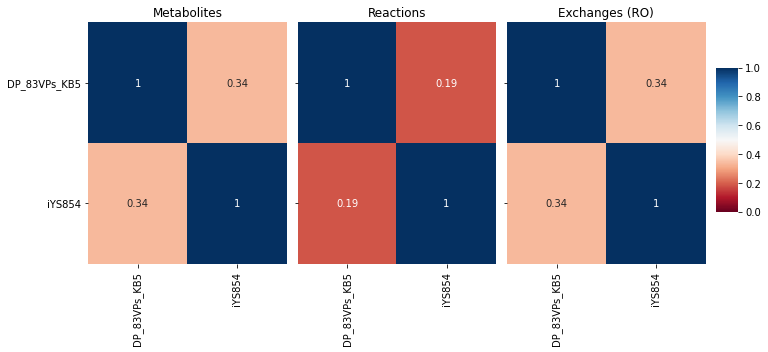

In [91]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(10,5))
titles = ["Metabolites", "Reactions", "Exchanges (RO)"]
cbar_ax = fig.add_axes([1.0, .4, .03, .4])
for i,df in enumerate([jmat1,mat2,df]):
    axes[i].set_title(titles[i])
    sns.heatmap(df, annot=True,cmap="RdBu", vmin=0.0, vmax=1.0, ax=axes[i],cbar_ax=cbar_ax)
    axes[i].set_yticklabels(df.index,rotation=0)
    axes[i].set_xticklabels(df.index,rotation=90) 
plt.tight_layout()

In [13]:
import pandas as pd 
df1 = pd.read_csv("results/default_project_name/analysis/flux_analysis/fva_iYS854_consistent_snm3.csv", index_col=0)
df2 = pd.read_csv("results/default_project_name/analysis/flux_analysis/fva_DP_83VPs_KB5_consistent_snm3.csv",index_col=0)
df_full = pd.DataFrame()
df_full["SA"] = df1["minimum"]
df_full["DP"] = df2["minimum"]


In [14]:
fvas = [df2,df1]

In [15]:
df = pd.concat(fvas)
df = df.groupby(df.index).min()

In [16]:
mediums = []
for model in models:
    medium = model.medium
    for key in medium:
        if key in df.index:
            flux = df.loc[key].minimum
            medium[key] = -flux
    mediums.append(medium)
    

In [22]:
models[1].slim_optimize()

2.5586946126133867

In [24]:
models[1].medium = mediums[1]
models[1].slim_optimize()

2.5586946126133867

In [24]:
models[0].slim_optimize()

0.282365392532248

In [6]:
compute_COMPM_pairwise(df1,df2)[0]

{'EX_arg__L_e': 10.0,
 'EX_pi_e': 5.519506278295115,
 'EX_mg2_e': 0.0239919081006363,
 'EX_ni2_e': 0.0099350749213039,
 'EX_cys__L_e': 10.0,
 'EX_glu__L_e': 10.0,
 'EX_val__L_e': 10.0,
 'EX_gly_e': 10.0,
 'EX_thm_e': 0.0011411777972255,
 'EX_ala__L_e': 10.0,
 'EX_thr__L_e': 0.1475150255062166,
 'EX_trp__L_e': 0.039250186925305,
 'EX_phe__L_e': 10.0,
 'EX_pro__L_e': 0.0599191019067427,
 'EX_his__L_e': 0.15415385138308,
 'EX_zn2_e': 0.0089150319739785,
 'EX_etha_e': 1.3319731495382118e-29,
 'EX_h2o_e': 10.0,
 'EX_4abz_e': 0.0001813389390676,
 'EX_cu2_e': 0.0091763970412923,
 'EX_o2_e': 20.0,
 'EX_so4_e': 0.0105571739716428,
 'EX_na1_e': 5.090522931794346,
 'EX_lys__L_e': 0.9223436956285932,
 'EX_orn_e': 10.0,
 'EX_glc__D_e': 10.0,
 'EX_cobalt2_e': 0.009894648965031,
 'EX_cl_e': 0.0164477851348533,
 'EX_leu__L_e': 0.8034579715954924,
 'EX_k_e': 0.4751240026161809,
 'EX_fe2_e': 0.0377612150930577,
 'EX_ribflv_e': 0.0007637848411345,
 'EX_nac_e': 7.953461359822285,
 'EX_co2_e': 0.1316647375